In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-04-29',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2024-12-03,26.55,27.5900,26.4907,27.44,6009926.0
2024-12-04,27.07,27.8300,26.6300,27.03,6387537.0
2024-12-05,27.00,30.8700,26.1501,28.63,40704909.0
2024-12-06,29.12,29.3500,28.1100,29.06,15161435.0
2024-12-09,29.00,29.8600,27.7400,27.93,11495415.0
...,...,...,...,...,...
2025-04-23,28.20,28.2500,26.9600,27.12,8862655.0
2025-04-24,27.10,27.5799,26.8360,27.08,6212122.0
2025-04-25,27.13,27.8000,27.1300,27.46,5853359.0
2025-04-28,27.40,27.5900,26.9800,27.59,6819305.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2024-12-03    1
2024-12-04    1
2024-12-05    1
2024-12-06    1
2024-12-09    1
             ..
2025-04-23    1
2025-04-24    1
2025-04-25    1
2025-04-28    1
2025-04-29    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

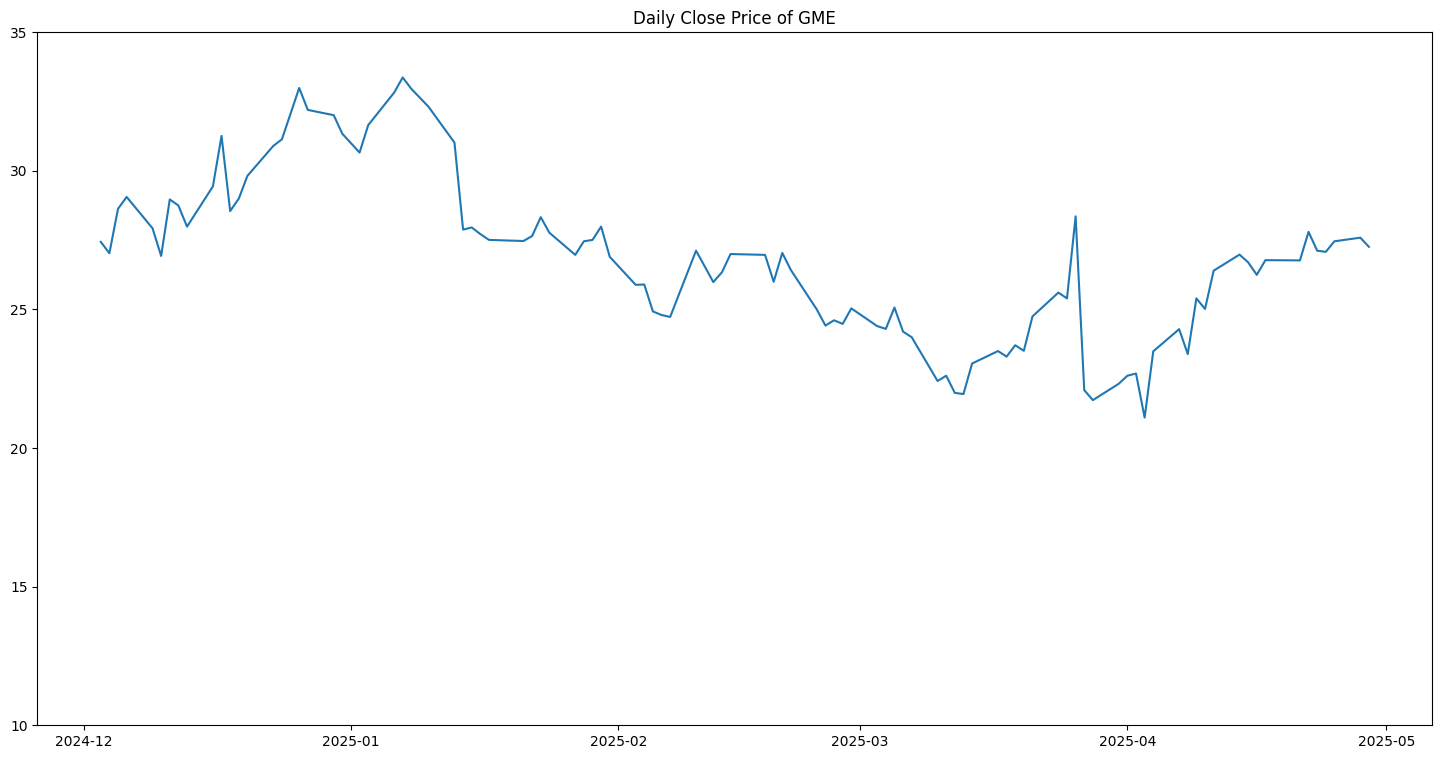

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

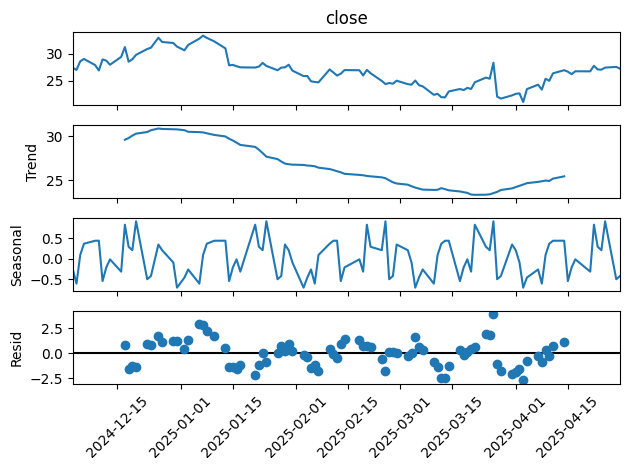

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': 'GameStop  ( GME )  Exceeds Market Returns: Some Facts to Consider',
  'url': 'https://www.zacks.com/stock/news/2457276/gamestop-gme-exceeds-market-returns-some-facts-to-consider',
  'time_published': '20250428T214517',
  'authors': ['Zacks Equity Research'],
  'summary': 'GameStop (GME) closed the most recent trading day at $27.59, moving +0.47% from the previous trading session.',
  'banner_image': 'https://staticx-tuner.zacks.com/images/default_article_images/default125.jpg',
  'source': 'Zacks Commentary',
  'category_within_source': 'n/a',
  'source_domain': 'www.zacks.com',
  'topics': [{'topic': 'Earnings', 'relevance_score': '0.938793'},
   {'topic': 'Retail & Wholesale', 'relevance_score': '1.0'},
   {'topic': 'Financial Markets', 'relevance_score': '0.161647'}],
  'overall_sentiment_score': 0.194144,
  'overall_sentiment_label': 'Somewhat-Bullish',
  'ticker_sentiment': [{'ticker': 'GME',
    'relevance_score': '0.599092',
    'ticker_sentiment_score': '0.366864',


In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,GameStop ( GME ) Exceeds Market Returns: Som...,20250428T214517,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,Bullish
1,GameStop Stakeholders Are Not Aligned on Bitco...,20250425T181225,André Beganski,When will GameStop buy Bitcoin after raising $...,Decrypt.co,0.183386,Somewhat-Bullish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.745397,0.318365,Somewhat-Bullish
2,Should You Invest in Bitcoin Now?,20250425T174500,Andrew Rocco,Bitcoin has broken away from the NASDAQ and is...,Zacks Commentary,0.216740,Somewhat-Bullish,"Life Sciences, Technology, Blockchain, Economy...",GME,0.058903,0.129051,Neutral
3,GameStop Gets Nintendo Switch 2 Boost: Should ...,20250425T142740,Surbhi Jain,GameStop offers up to $175 off Switch 2 preord...,Benzinga,0.410144,Bullish,"Retail & Wholesale, Financial Markets",GME,0.830869,0.66996,Bullish
4,Here's How Much You'd Have If You Invested $10...,20250425T123003,Zacks Equity Research,Holding on to popular or trending stocks for t...,Zacks Commentary,0.166470,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.591019,0.236662,Somewhat-Bullish
5,RTFKT's CloneX avatars reappear after issue bl...,20250425T081512,Brayden Lindrea,"More than 19,800 CloneX digital avatars develo...",Cointelegraph,-0.140063,Neutral,"Retail & Wholesale, Manufacturing, Technology,...",GME,0.100729,-0.072292,Neutral
6,UiPath ( PATH ) and GameStop ( GME ) Are A...,20250424T223300,Brian Bolan,Two More Stocks for your Aggressive Growth Sto...,Zacks Commentary,0.124737,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.224903,0.012442,Neutral
7,Nintendo Stock Hits All-Time High Amid Switch ...,20250424T175445,Adam Eckert,Nintendo stock is hitting all-time highs amid ...,Benzinga,0.106721,Neutral,"Retail & Wholesale, Financial Markets",GME,0.259267,-0.110219,Neutral
8,GameStop Stock Rises Amid Switch 2 Preorders: ...,20250424T150837,Henry Khederian,GameStop may be seeing a small bump in share p...,Benzinga,0.305812,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.733479,0.405381,Bullish
9,Best Non Gamstop Casinos UK: JACKBIT Ranked as...,20250424T141331,Globe Newswire,"LARNACA, Cyprus, April 24, 2025 ( GLOBE NEWSWI...",Benzinga,0.399638,Bullish,"Retail & Wholesale, Blockchain",GME,0.096736,0.268063,Somewhat-Bullish


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Zacks Equity Research', 'André Beganski', 'Andrew Rocco',
       'Surbhi Jain', 'Brayden Lindrea', 'Brian Bolan', 'Adam Eckert',
       'Henry Khederian', 'Globe Newswire', 'Bram Berkowitz',
       'Rishabh Mishra', 'Vaishali Prayag', 'Benzinga Insights',
       'Aniket Verma', 'Motley Fool Staff', 'Stephen Katte',
       'Derek Lewis', 'Ritujay Ghosh', 'Sanghamitra Saha', 'Nalak Das',
       'Akanksha Bakshi', 'Murtuza J Merchant', 'Proiti Seal Acharya',
       'Alex O’Donnell', '', 'Liz Napolitano', 'Sam Bourgi', 'Big Smokey',
       'Khyathi Dalal'], dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-04-28,GameStop ( GME ) Exceeds Market Returns: Som...,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,Bullish
2025-04-25,GameStop Stakeholders Are Not Aligned on Bitco...,André Beganski,When will GameStop buy Bitcoin after raising $...,Decrypt.co,0.183386,Somewhat-Bullish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.745397,0.318365,Somewhat-Bullish
2025-04-25,Should You Invest in Bitcoin Now?,Andrew Rocco,Bitcoin has broken away from the NASDAQ and is...,Zacks Commentary,0.216740,Somewhat-Bullish,"Life Sciences, Technology, Blockchain, Economy...",GME,0.058903,0.129051,Neutral
2025-04-25,GameStop Gets Nintendo Switch 2 Boost: Should ...,Surbhi Jain,GameStop offers up to $175 off Switch 2 preord...,Benzinga,0.410144,Bullish,"Retail & Wholesale, Financial Markets",GME,0.830869,0.66996,Bullish
2025-04-25,Here's How Much You'd Have If You Invested $10...,Zacks Equity Research,Holding on to popular or trending stocks for t...,Zacks Commentary,0.166470,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.591019,0.236662,Somewhat-Bullish
2025-04-25,RTFKT's CloneX avatars reappear after issue bl...,Brayden Lindrea,"More than 19,800 CloneX digital avatars develo...",Cointelegraph,-0.140063,Neutral,"Retail & Wholesale, Manufacturing, Technology,...",GME,0.100729,-0.072292,Neutral
2025-04-24,UiPath ( PATH ) and GameStop ( GME ) Are A...,Brian Bolan,Two More Stocks for your Aggressive Growth Sto...,Zacks Commentary,0.124737,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.224903,0.012442,Neutral
2025-04-24,Nintendo Stock Hits All-Time High Amid Switch ...,Adam Eckert,Nintendo stock is hitting all-time highs amid ...,Benzinga,0.106721,Neutral,"Retail & Wholesale, Financial Markets",GME,0.259267,-0.110219,Neutral
2025-04-24,GameStop Stock Rises Amid Switch 2 Preorders: ...,Henry Khederian,GameStop may be seeing a small bump in share p...,Benzinga,0.305812,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.733479,0.405381,Bullish


In [24]:
news.groupby(news.index.date).size()

2025-04-02    3
2025-04-03    1
2025-04-04    4
2025-04-07    4
2025-04-08    5
2025-04-09    1
2025-04-10    2
2025-04-11    4
2025-04-14    2
2025-04-15    1
2025-04-16    2
2025-04-17    2
2025-04-18    1
2025-04-21    1
2025-04-22    2
2025-04-23    4
2025-04-24    5
2025-04-25    5
2025-04-28    1
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-04-07,Crypto veterans seek to make publicly traded J...,,A small publicly traded software company is lo...,CNBC,0.300048,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.051441,0.106461,Neutral
2025-04-02,Conservative cable channel Newsmax shares plun...,,"The stock tumbled a whopping 72% Wednesday, fo...",CNBC,0.099891,Neutral,"IPO, Retail & Wholesale, Financial Markets, Te...",GME,0.410059,0.137479,Neutral


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-04-28,GameStop ( GME ) Exceeds Market Returns: Som...,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,Bullish
2025-04-25,GameStop Stakeholders Are Not Aligned on Bitco...,André Beganski,When will GameStop buy Bitcoin after raising $...,Decrypt.co,0.183386,Somewhat-Bullish,"Economy - Monetary, Retail & Wholesale, Financ...",GME,0.745397,0.318365,Somewhat-Bullish
2025-04-25,Should You Invest in Bitcoin Now?,Andrew Rocco,Bitcoin has broken away from the NASDAQ and is...,Zacks Commentary,0.216740,Somewhat-Bullish,"Life Sciences, Technology, Blockchain, Economy...",GME,0.058903,0.129051,Neutral
2025-04-25,GameStop Gets Nintendo Switch 2 Boost: Should ...,Surbhi Jain,GameStop offers up to $175 off Switch 2 preord...,Benzinga,0.410144,Bullish,"Retail & Wholesale, Financial Markets",GME,0.830869,0.66996,Bullish
2025-04-25,Here's How Much You'd Have If You Invested $10...,Zacks Equity Research,Holding on to popular or trending stocks for t...,Zacks Commentary,0.166470,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Earning...",GME,0.591019,0.236662,Somewhat-Bullish
2025-04-25,RTFKT's CloneX avatars reappear after issue bl...,Brayden Lindrea,"More than 19,800 CloneX digital avatars develo...",Cointelegraph,-0.140063,Neutral,"Retail & Wholesale, Manufacturing, Technology,...",GME,0.100729,-0.072292,Neutral
2025-04-24,UiPath ( PATH ) and GameStop ( GME ) Are A...,Brian Bolan,Two More Stocks for your Aggressive Growth Sto...,Zacks Commentary,0.124737,Neutral,"Earnings, Retail & Wholesale, Financial Markets",GME,0.224903,0.012442,Neutral
2025-04-24,Nintendo Stock Hits All-Time High Amid Switch ...,Adam Eckert,Nintendo stock is hitting all-time highs amid ...,Benzinga,0.106721,Neutral,"Retail & Wholesale, Financial Markets",GME,0.259267,-0.110219,Neutral
2025-04-24,GameStop Stock Rises Amid Switch 2 Preorders: ...,Henry Khederian,GameStop may be seeing a small bump in share p...,Benzinga,0.305812,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.733479,0.405381,Bullish


In [27]:
news['overall_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Bullish', 'Neutral'], dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Bullish', 'Somewhat-Bullish', 'Neutral', 'Somewhat-Bearish'],
      dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_17508\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_17508\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-12-03,26.55,27.59,26.4907,27.44,6009926.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-04,27.07,27.83,26.6300,27.03,6387537.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-05,27.00,30.87,26.1501,28.63,40704909.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-06,29.12,29.35,28.1100,29.06,15161435.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-12-09,29.00,29.86,27.7400,27.93,11495415.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-25,27.13,27.80,27.1300,27.46,5853359.0,GameStop Gets Nintendo Switch 2 Boost: Should ...,Surbhi Jain,GameStop offers up to $175 off Switch 2 preord...,Benzinga,0.410144,5.0,"Retail & Wholesale, Financial Markets",GME,0.830869,0.66996,5.0
2025-04-25,27.13,27.80,27.1300,27.46,5853359.0,Here's How Much You'd Have If You Invested $10...,Zacks Equity Research,Holding on to popular or trending stocks for t...,Zacks Commentary,0.166470,4.0,"Retail & Wholesale, Financial Markets, Earning...",GME,0.591019,0.236662,4.0
2025-04-25,27.13,27.80,27.1300,27.46,5853359.0,RTFKT's CloneX avatars reappear after issue bl...,Brayden Lindrea,"More than 19,800 CloneX digital avatars develo...",Cointelegraph,-0.140063,3.0,"Retail & Wholesale, Manufacturing, Technology,...",GME,0.100729,-0.072292,3.0
2025-04-28,27.40,27.59,26.9800,27.59,6819305.0,GameStop ( GME ) Exceeds Market Returns: Som...,Zacks Equity Research,GameStop (GME) closed the most recent trading ...,Zacks Commentary,0.194144,4.0,"Earnings, Retail & Wholesale, Financial Markets",GME,0.599092,0.366864,5.0


In [31]:
merged_df = merged_df.drop(columns = ['title','topics','ticker','close','authors','summary','source'])

In [36]:
def create_lstm_dataset(data, target_column, look_back):
    """
    Convert a dataframe into LSTM-compatible 3D sequences for a specific target column.
    
    Parameters:
    - data: pandas DataFrame (rows = time, cols = features)
    - target_column: name of the column to predict (e.g., 'Close')
    - look_back: number of past time steps to include

    Returns:
    - X: shape (num_samples, look_back, num_features)
    - y: shape (num_samples,)
    """
    # Extract features and target column
    features = data.drop(columns=[target_column]).values  # All columns except target
    target = data[target_column].values  # Target column
    
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(features[i:i+look_back])  # Look-back window of features
        y.append(target[i + look_back])  # Next time-step's target value
        
    return np.array(X), np.array(y)

look_back = 10
X, y = create_lstm_dataset(df, target_column='close', look_back=look_back)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False)
# need to split in such a way that both resulting numbers are divisible by the look_back

In [ ]:
# need to fix

def trim_for_reshape(arr: np.ndarray, look_back: int, num_features: int) -> np.ndarray:
    total_required = look_back * num_features
    remainder = arr.size % total_required
    
    if remainder != 0:
        arr = arr[:-remainder]  # remove from end
    return arr.reshape(-1, look_back, num_features)
trim_for_reshape

In [ ]:
# need to fix

X_train = np.array(X_train).reshape(-1, look_back, 9)
X_test = np.array(X_test).reshape(-1, look_back, 9)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Needed for val_loss monitoring
    epochs=1000,
    batch_size=240,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Stock Prices", color="blue")
plt.plot(y_pred, label="Predicted Stock Prices", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices (Using News Sentiment)")
plt.legend()
plt.show()